In [1]:
import segmentation_models as sm
import os, cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

Segmentation Models: using `tf.keras` framework.


# Segmentation Model Parameters

In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
BACKBONE = 'resnet18'
CLASSES = ['papaya']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1) 
activation = 'sigmoid' if n_classes == 1 else 'softmax'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Define Function

In [3]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASSES = ['papaya']
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        if len(np.unique(mask))>2: # 我自己加的
            mask[mask>127] = 255
            mask[mask<=127] = 0
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
def get_preprocessing(preprocessing_fn):    
    return A.Compose([A.Lambda(image=preprocessing_fn),])

class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

# Loading Dataset

In [10]:
DATA_DIR = './03_unet_image'
#DATA_DIR = '//Users/jackhsiao/Documents/07_AIGO教學/03_unet_image'
x_valid_dir = os.path.join(DATA_DIR, 'image/test')
y_valid_dir = os.path.join(DATA_DIR, 'mask/test')

In [11]:
test_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES, preprocessing = get_preprocessing(preprocess_input))
test_dataset = Dataloder(test_dataset, batch_size=1, shuffle=False)

# Loading Model

In [12]:
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, input_shape=(320, 640, 3))
optim = keras.optimizers.Adam()
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)
model.load_weights('04_unet_training/best_model.h5') 

2022-11-18 19:59:27.970735: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-18 19:59:27.972459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model Evaluation

In [ ]:
scores = model.evaluate(test_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Visualization of Dataset

In [14]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

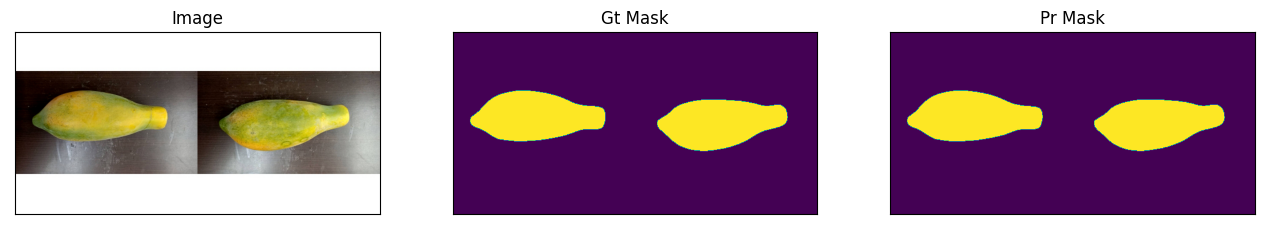

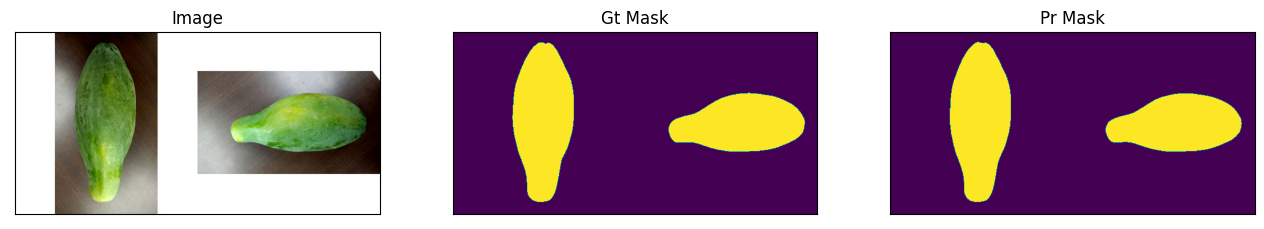

In [16]:
ids = np.random.choice(np.arange(len(test_dataset)), size=2)
for i in ids:
    image, gt_mask = test_dataset[i]
    #image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

# Plot training with each epoch

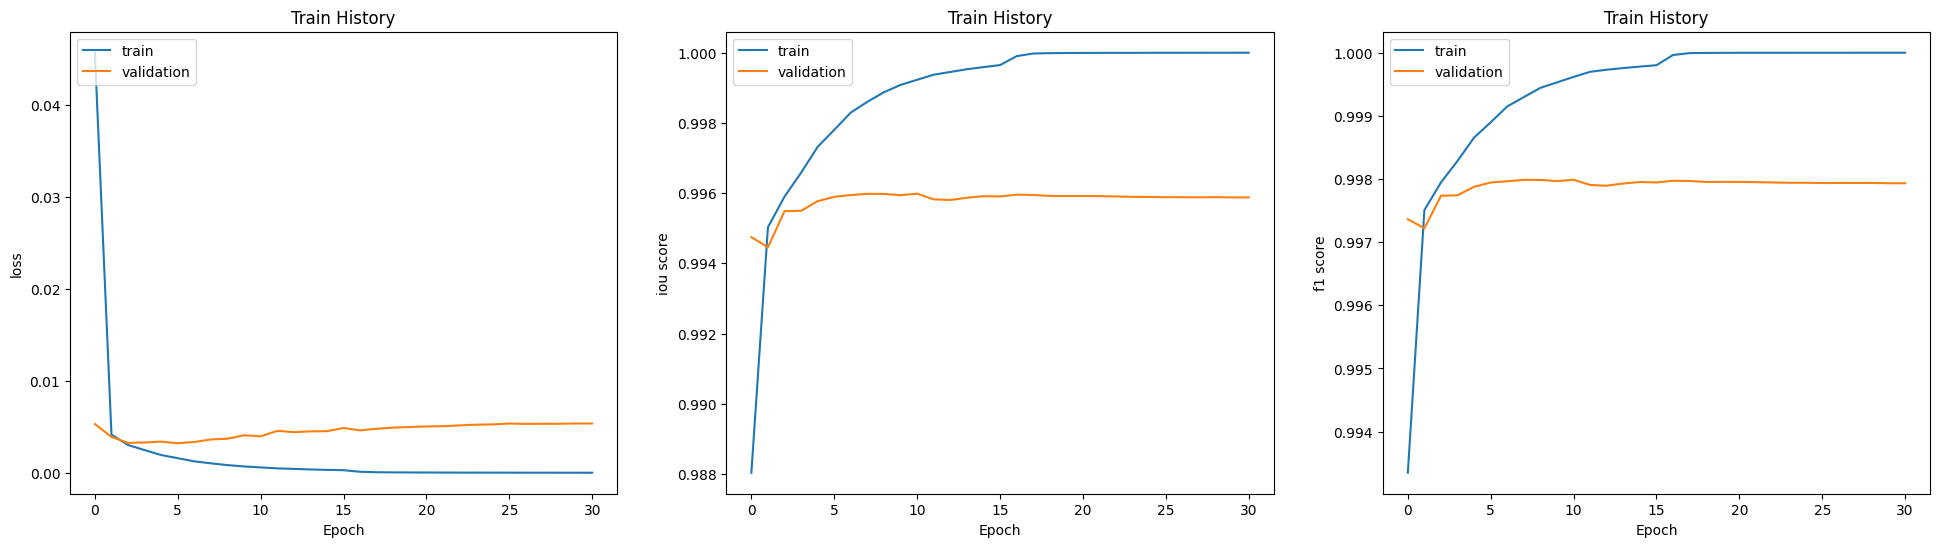

In [21]:
def show_train_history(train_history):
    fig=plt.gcf()
    fig.set_size_inches(24, 6)
    plt.subplot(131)
    plt.plot(train_history[0])
    plt.plot(train_history[1])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(132)
    plt.plot(train_history[2])
    plt.plot(train_history[3])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("iou score")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(133)
    plt.plot(train_history[4])
    plt.plot(train_history[5])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("f1 score")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.close(fig)
    return fig

with open("04_unet_training/history.txt") as f:
    lines = f.readlines()
loss = list(map(lambda x:float(x), lines[0].split("], ")[0].split("[")[1].split(",")))
iou_score = list(map(lambda x:float(x), lines[0].split("], ")[1].split("[")[1].split(",")))
f1_score = list(map(lambda x:float(x), lines[0].split("], ")[2].split("[")[1].split(",")))
val_loss = list(map(lambda x:float(x), lines[0].split("], ")[3].split("[")[1].split(",")))
val_iou_score = list(map(lambda x:float(x), lines[0].split("], ")[4].split("[")[1].split(",")))
val_f1_score = list(map(lambda x:float(x), lines[0].split("], ")[5].split("[")[1].split(",")))
show_train_history([loss,val_loss, iou_score, val_iou_score, f1_score, val_f1_score])